In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
# Load in data
ts = pd.read_csv('Data/MA_lesson_ts.csv', index_col = 'date')
ts.head()

,value
date,
2000-01-31,0.332798
2000-02-29,0.057122
2000-03-31,0.691783
2000-04-30,1.132335
2000-05-31,0.692867


In [6]:
# We have monthly data so we will set our frequency to M
ts.index.freq = "M"

In [7]:
# Define the series
ts = ts['value']

In [8]:
# Check for nulls
ts.isna().sum()

0

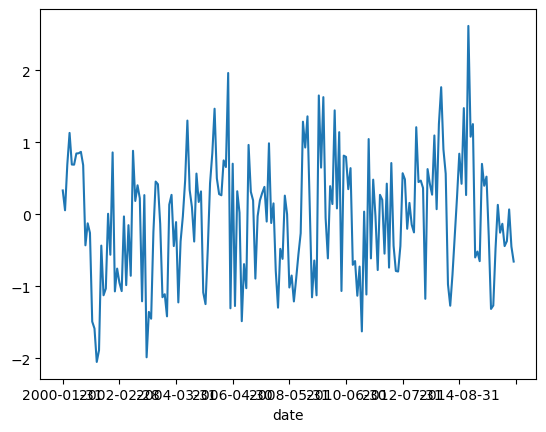

In [9]:
# Plot the time series
ts.plot();

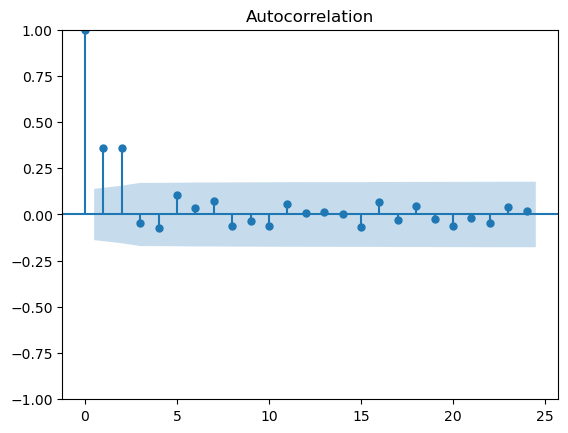

In [10]:
# Make acf plot of raw data to look for seasonality
tsa.graphics.plot_acf(ts);

In [11]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-4.254855,9,190,0.000531,0.05,True


In [12]:
# check differencing with ndiffs
d = ndiffs(ts)
print (f'd = {d}')

d = 0


In [13]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

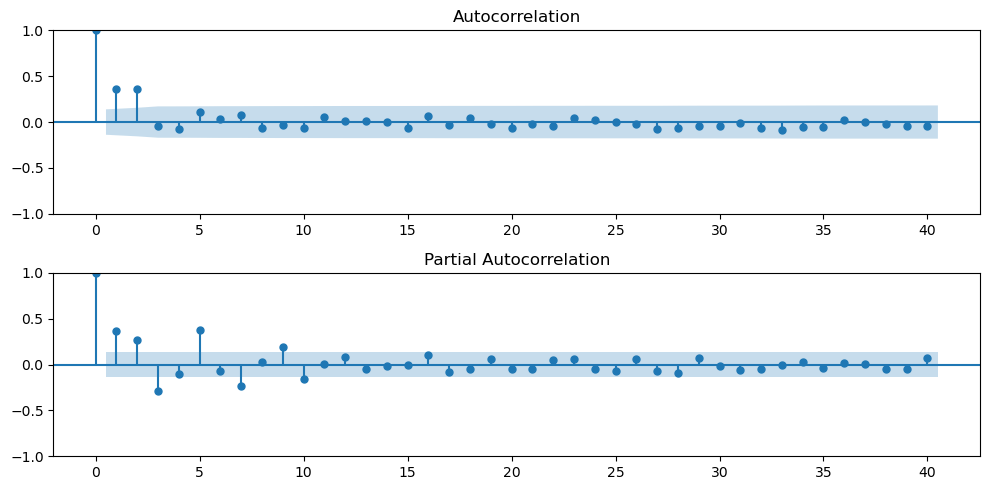

In [14]:
# Let's call our custom acf/pacf plot on our stationary (d = 0) data
plot_acf_pacf(ts);

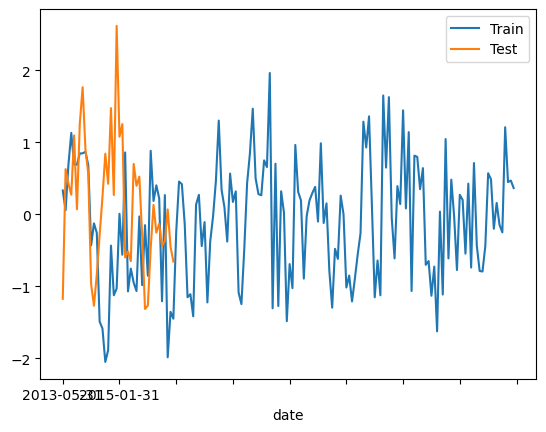

In [15]:
# tts
train, test = train_test_split(ts, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [16]:
# First define the orders (p,d,q)
p = 0 # p is us ed for AR models (set to 0 for an MA only model)
d = 0 # no differcing was required to make the data stationary
q = 2 # q based on significant lags in ACF
# Now instantiate the model with the data and fit
ma_2_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ma_2_model

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [17]:
# Obtain the parameters of the fit model
ma_2_model.params

const    -0.105130
ma.L1     0.446952
ma.L2     0.946894
sigma2    0.379158
dtype: float64

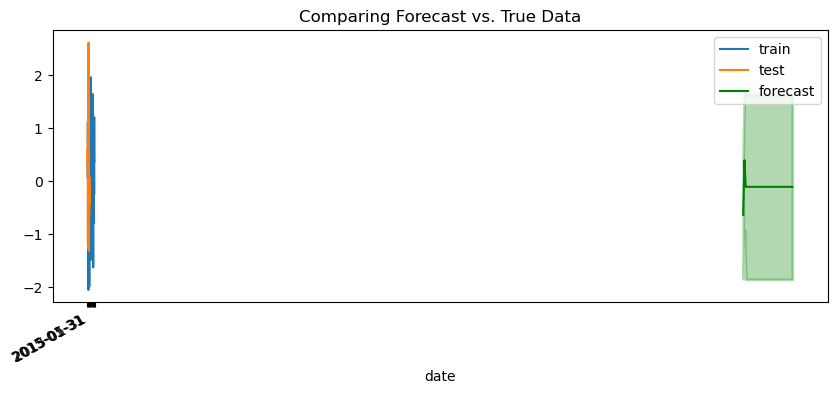

In [18]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = ma_2_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

## Combining AR and MA Models

In [19]:
# Load in data
ts = pd.read_csv('Data/AR_MA_lesson_ts.csv', parse_dates = ['date'], index_col = 'date')
ts.head()

,value
date,
2022-05-25,-0.148001
2022-05-26,-0.187799
2022-05-27,-0.034606
2022-05-28,0.304207
2022-05-29,0.228702


In [20]:
# We have daily data so we will set our frequency to D
ts.index.freq= "D"
ts.index

DatetimeIndex(['2022-05-25', '2022-05-26', '2022-05-27', '2022-05-28',
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03',
               ...
               '2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04',
               '2022-12-05', '2022-12-06', '2022-12-07', '2022-12-08',
               '2022-12-09', '2022-12-10'],
              dtype='datetime64[ns]', name='date', length=200, freq='D')

In [21]:
# Check for nulls
ts.isna().sum().sum()

0

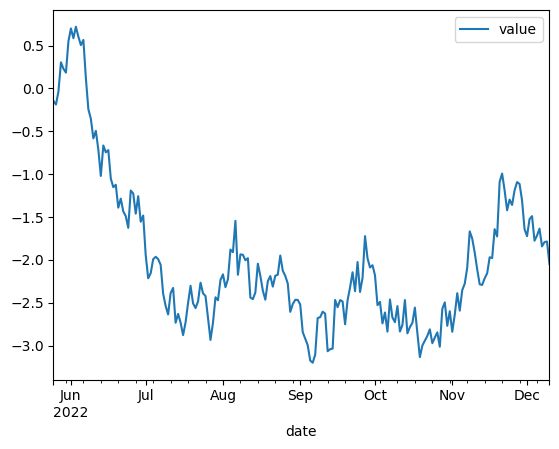

In [22]:
# Plot the time series
ts.plot();

In [23]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.258272,1,198,0.185779,0.05,False


In [24]:
# Check to see how many differencing are needed
ndiffs(ts)

1

In [25]:
# We need to apply differencing one time
ts_diff = ts.diff().dropna()
# Confirm stationarity with adfuller test
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-15.726403,0,198,0.0,0.05,True


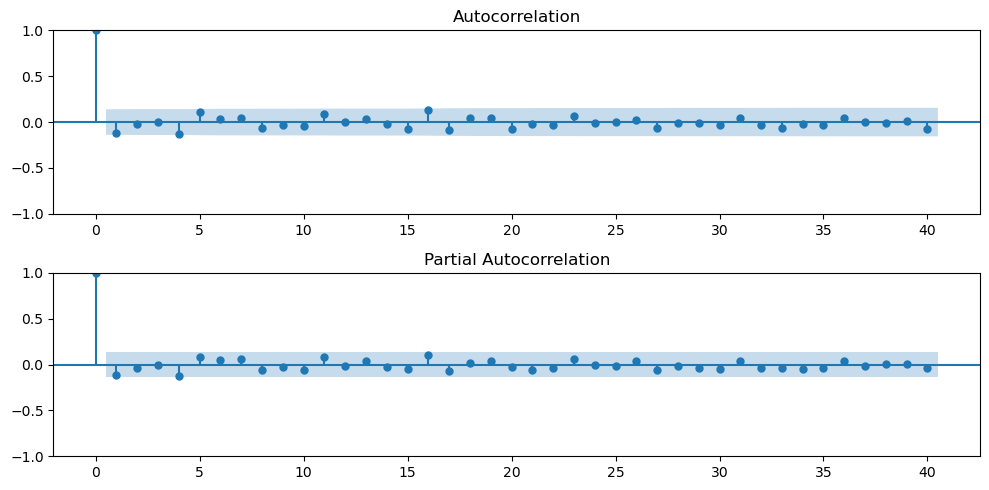

In [26]:
# Let's call our custom acf/pacf plot on our stationary (d = 1) data
plot_acf_pacf(ts_diff);

In [27]:
# First define the orders (p,d,q)
p = 1 # p is used for AR component of AR-MA model
d = 1 # 1 differcing needed to make stationary
q = 1 # q is used for MA component of AR-MA model
# Now instantiate the model with the data and fit
ar_ma_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_ma_model

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [28]:
# Obtain the parameters of the fit model
ar_ma_model.params

ar.L1    -0.629612
ma.L1     0.144928
sigma2    0.670682
dtype: float64

## Comparing Models

In [29]:
# Obtain summary of model
ma_2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -151.744
Date:                Tue, 09 Jan 2024   AIC                            311.487
Time:                        16:48:56   BIC                            323.788
Sample:                    01-31-2000   HQIC                           316.482
                         - 04-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1051      0.125     -0.844      0.399      -0.349       0.139
ma.L1          0.4470      0.037     12.114      0.000       0.375       0.519
ma.L2          0.9469      0.040     23.858      0.000       0.869       1.025
sigma2         0.3792      0.043      8.804      0.000       0.295       0.464
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.33   Prob(JB):                         0.99
Heteroskedasticity (H):               1.18   Skew:                             0.01
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

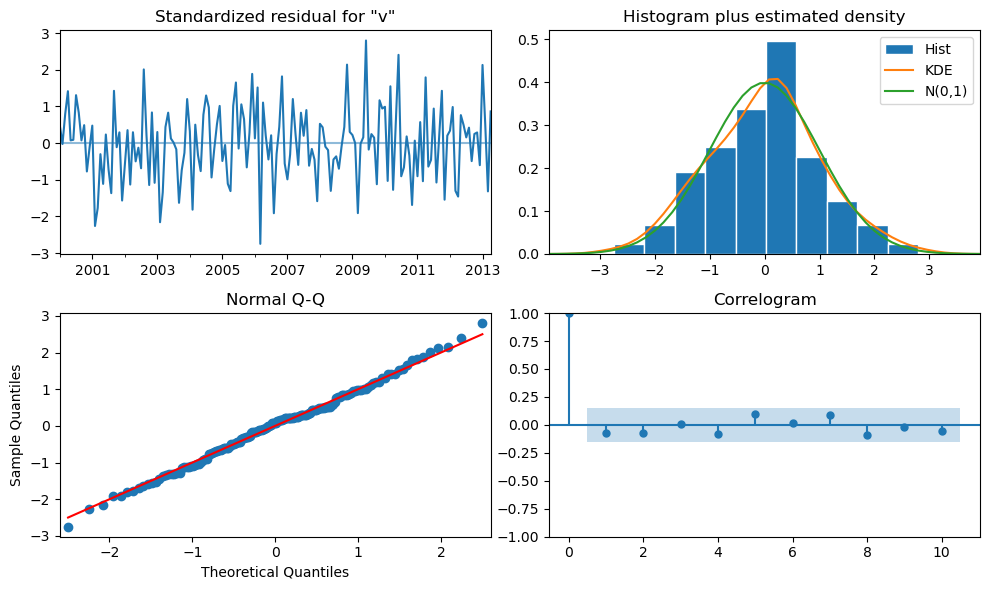

In [30]:
# Obtain diagnostic plots
fig = ma_2_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

In [32]:
# First define the orders (p,d,q)
p = 0 
d = 0 
q = 1 

# Now instantiate the model with the data and fit
ma_1_model = tsa.ARIMA(train, order = (p,d,q)).fit()

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [33]:
# Obtain model summary
ma_1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -192.028
Date:                Tue, 09 Jan 2024   AIC                            390.055
Time:                        19:51:46   BIC                            399.281
Sample:                    01-31-2000   HQIC                           393.801
                         - 04-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1047      0.076     -1.379      0.168      -0.254       0.044
ma.L1          0.1920      0.076      2.517      0.012       0.042       0.342
sigma2         0.6455      0.085      7.569      0.000       0.478       0.813
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.33   Prob(JB):                         0.39
Heteroskedasticity (H):               0.97   Skew:                            -0.02
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

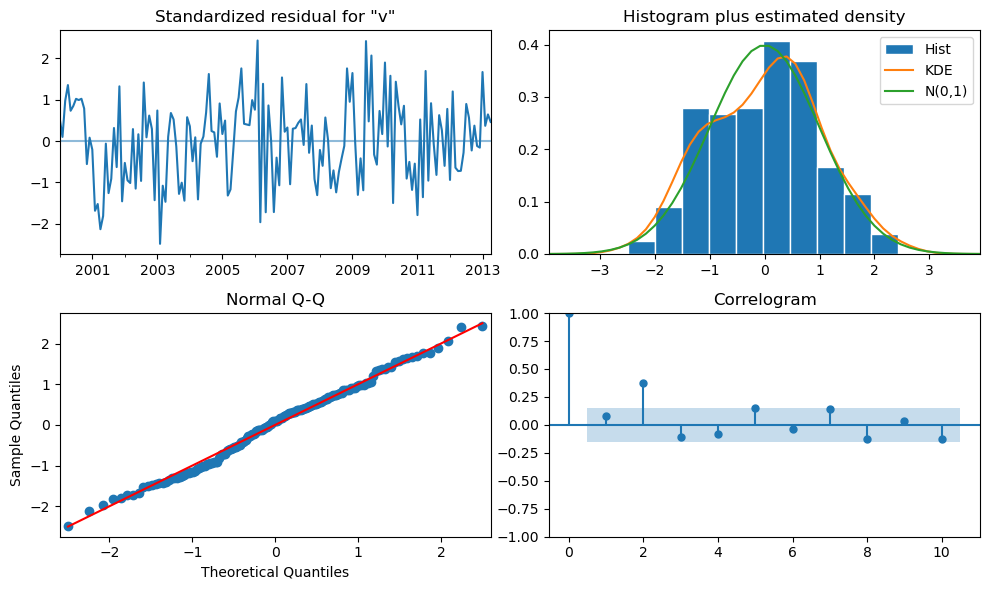

In [34]:
# Obtain diagnostic plots
fig = ma_1_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

In [35]:
# First define the orders (p,d,q)
p = 1 
d = 0 
q = 2  

# Now instantiate the model with the data and fit
ar_1_ma_2_model = tsa.ARIMA(train, order = (p,d,q)).fit()

C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [36]:
ar_1_ma_2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -151.097
Date:                Tue, 09 Jan 2024   AIC                            312.193
Time:                        19:54:39   BIC                            327.569
Sample:                    01-31-2000   HQIC                           318.437
                         - 04-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1060      0.111     -0.953      0.340      -0.324       0.112
ar.L1         -0.1002      0.090     -1.112      0.266      -0.277       0.076
ma.L1          0.4705      0.028     16.983      0.000       0.416       0.525
ma.L2          0.9721      0.036     26.767      0.000       0.901       1.043
sigma2         0.3733      0.042      8.804      0.000       0.290       0.456
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.94   Prob(JB):                         0.91
Heteroskedasticity (H):               1.15   Skew:                             0.08
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

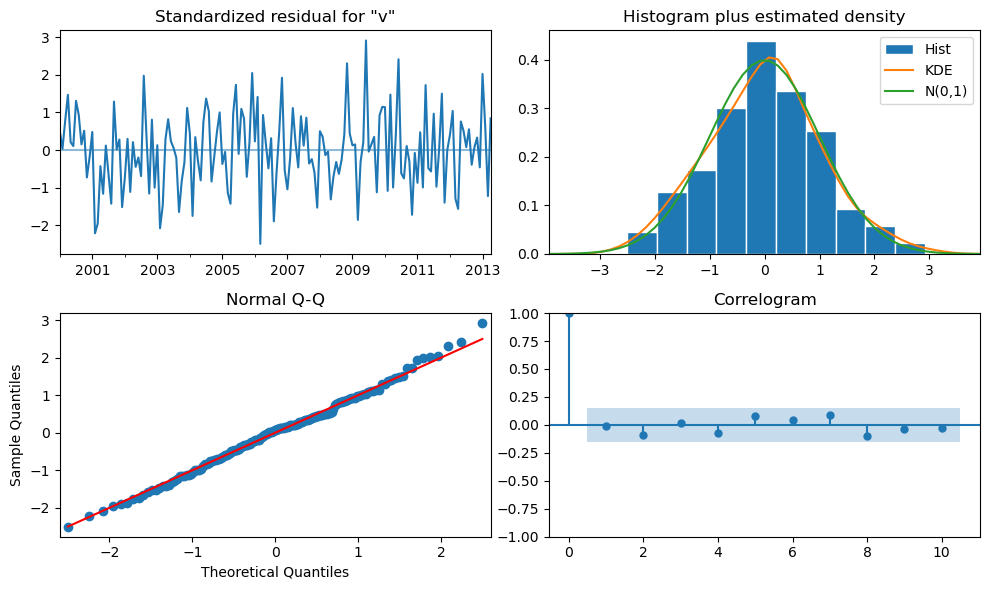

In [37]:
# Obtain diagnostic plots
fig = ar_1_ma_2_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

In [38]:
# Looking at AIC of all three models
print(f'MA(2) had an AIC of {ma_2_model.aic.round(2)}')
print(f'MA(1) had an AIC of {ma_1_model.aic.round(2)}')
print(f'AR(1)MA(2) had an AIC of {ar_1_ma_2_model.aic.round(2)}')

MA(2) had an AIC of 311.49
MA(1) had an AIC of 390.06
AR(1)MA(2) had an AIC of 312.19


In [40]:
# Looking at BIC of all three models
print(f'MA(2) had a BIC of {ma_2_model.bic.round(2)}')
print(f'MA(1) had a BIC of {ma_1_model.bic.round(2)}')
print(f'AR(1)MA(2) had a BIC of {ar_1_ma_2_model.bic.round(2)}')

MA(2) had a BIC of 323.79
MA(1) had a BIC of 399.28
AR(1)MA(2) had a BIC of 327.57
